In [15]:
import tensorflow as tf
import tensorflow.keras as kr
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

physical_device = tf.config.experimental.list_physical_devices("GPU")
print(physical_device)

# 限制显存使用
tf.config.experimental.set_memory_growth(physical_device[0], True)

# load data set, need mnist.npz in current work folder
with np.load("resources/mnist.npz", allow_pickle=True) as f:
    x_train, y_train = f["x_train"], f["y_train"]
    x_test, y_test = f["x_test"], f["y_test"]

print(x_train.shape, x_test.shape)

# 数据重塑至四维 b w h c
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# 数据转换为float32
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# 数据集归一到[-1,1]
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
(60000, 28, 28) (10000, 28, 28)


In [17]:
# Prepare for datasets
BATCH_SIZE = 128
SEED_PIC_NUMS = 16
NOISE_DIM = 100

def gen_datasets():
    global datasets, train_round
    datasets = (
        tf.data.Dataset.from_tensor_slices(x_train)
        .shuffle(x_train.shape[0])
        .batch(BATCH_SIZE)
    )
    train_round = tf.math.ceil(x_train.shape[0] / BATCH_SIZE)
    train_round = tf.cast(train_round, tf.int32)

def generator_model(NOISE_DIM):
    model = tf.keras.Sequential()

    # When a popular kwarg `input_shape` is passed, then keras will create
    # an input layer to insert before the current layer. This can be treated
    # equivalent to explicitly defining an `InputLayer`.

    model.add(tf.keras.Input(shape=(NOISE_DIM,)))

    model.add(tf.keras.layers.Dense(256, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(512, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(28 * 28, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('tanh')) #!!! 值域是[-1,1]

    model.add(tf.keras.layers.Reshape((28, 28, 1)))
    
    return model


def discrimmer_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(256, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(1))

    return model

# 损失函数 cross entropy loss 二分类的交叉熵损失 没有经过概率化输出
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 优化器
discrimmer_optimzer = tf.keras.optimizers.legacy.Adam(1e-4)
generator_optimzer = tf.keras.optimizers.legacy.Adam(1e-4)

In [18]:
seed = tf.random.normal((SEED_PIC_NUMS,NOISE_DIM))
generator = generator_model(NOISE_DIM)
discrimmer = discrimmer_model()

In [34]:
# Prepare for checkpoints
import os

checkpoint = tf.train.Checkpoint(
    step=tf.Variable(1),
    generator_optimizer=generator_optimzer,
    discriminator_optimizer=discrimmer_optimzer,
    generator=generator,
    discriminator=discrimmer,
)
checkpoint_dir = "./checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

In [40]:
LOSS_FILTER_FATCOR = 0.8  # 损失滤波
gen_loss, disc_loss, seed_fake_loss = 0.0, 0.0, 0.0


# real -> 1 fake -> 0
# 尝试最大化损失
def discrimmer_loss(real_out, fake_out):
    image_real_loss = cross_entropy(0.9 * tf.ones_like(real_out), real_out)
    image_fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    return image_real_loss + image_fake_loss


# 尝试最小化损失
def generator_loss(fake_out):
    return cross_entropy(0.9 * tf.ones_like(fake_out), fake_out)


# 输出图像
def output_image(seed):
    gen_images = generator.call(inputs=seed, training=False)
    fake_out = discrimmer.call(inputs=gen_images, training=False)
    fake_loss = generator_loss(fake_out)
    gen_images = gen_images.numpy()
    gen_images = gen_images.reshape(gen_images.shape[0], 28, 28)

    plt.figure(figsize=(16, 1))
    for i in range(seed.shape[0]):
        plt.subplot(1, seed.shape[0], i + 1)
        plt.axis("off")
        plt.imshow(gen_images[i], cmap="binary")
    plt.show()

    return fake_loss


@tf.function
def train_steps(real_images):
    # Make some noise images
    noise = tf.random.normal((BATCH_SIZE, NOISE_DIM))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images = generator.call(inputs=noise, training=True)

        real_out = discrimmer.call(inputs=real_images, training=True)
        fake_out = discrimmer.call(inputs=gen_images, training=True)

        disc_loss = discrimmer_loss(real_out, fake_out)
        gen_loss = generator_loss(fake_out)

    gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discrimmer.trainable_variables)

    # Apply gradient to variables
    generator_optimzer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    discrimmer_optimzer.apply_gradients(
        zip(disc_gradient, discrimmer.trainable_variables)
    )
    return [disc_loss, gen_loss]


def train(epoches):
    if ckpt_manager.latest_checkpoint:
        checkpoint.restore(ckpt_manager.latest_checkpoint)
        print("Restored from {}".format(ckpt_manager.latest_checkpoint))
    else:
        print("Start training.")

    for e in range(epoches):
        print("epoch: {}/{}".format(e + 1, epoches))
        i = 0
        round_gen_loss, round_disc_loss = 0.0, 0.0
        for image in datasets:
            i += 1
            losses = train_steps(image)
            round_gen_loss += losses[0]
            round_disc_loss += losses[1]
            if i % 20 == 0:
                print("{}/{}".format(i, train_round), end=" ")

        checkpoint.step.assign_add(1)

        if (e + 1) % 5 == 0:
            save_path = ckpt_manager.save()
            print("Save checkpoint for step {}:{}".format(int(checkpoint.step), save_path))

        print(end="\n")

        global gen_loss, disc_loss, seed_fake_loss
        train_round_fl = tf.cast(train_round, tf.float32)
        gen_loss = (
            LOSS_FILTER_FATCOR * gen_loss
            + (1.0 - LOSS_FILTER_FATCOR) * round_gen_loss / train_round_fl
        )
        disc_loss = ( 
            LOSS_FILTER_FATCOR * disc_loss
            + (1.0 - LOSS_FILTER_FATCOR) * round_disc_loss / train_round_fl
        )
        seed_fake_loss = LOSS_FILTER_FATCOR * seed_fake_loss + (
            1.0 - LOSS_FILTER_FATCOR
        ) * output_image(seed)
        print(
            "gen_loss:{:.4f}, disc_loss:{:.4f}, total_loss:{:.4f} seed_gen_loss:{:.4f}".format(
                gen_loss, disc_loss, gen_loss + disc_loss, seed_fake_loss
            )
        )

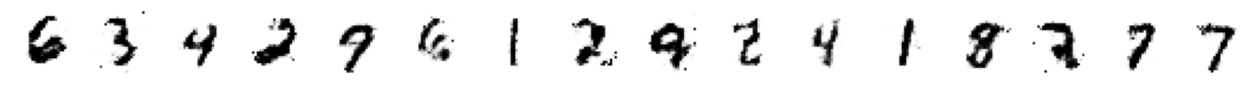

<tf.Tensor: shape=(), dtype=float32, numpy=1.0800388>

In [52]:
output_image(seed)

In [41]:
# Restore from latest checkpoint
print(ckpt_manager.latest_checkpoint)
checkpoint.restore(ckpt_manager.latest_checkpoint)

./checkpoints/ckpt-52
